In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Bayesian POLIMI

Mounted at /gdrive
/gdrive/My Drive/Bayesian POLIMI


In [ ]:
# Install cmdstanpy module
!pip install cmdstanpy

!pip list | grep cmdstanpy


cmdstanpy                          1.2.4


In [ ]:
# Install arviz module (With version 2.33.1 you will need a special version of arviz)
!pip install arviz
!pip list | grep arviz

arviz                              0.20.0


In [ ]:
# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan
install_cmdstan()

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.35.0
Download successful, file: /tmp/tmp70k9mw9p
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.35.0
Building version cmdstan-2.35.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.35.0
Test model compilation


True

In [ ]:
from cmdstanpy import cmdstan_path
cmdstan_path()

'/root/.cmdstan/cmdstan-2.35.0'

In [ ]:
# Create folder to store .stan files
import os
if not os.path.exists("./stan"):
    os.mkdir("./stan")

# Import modules
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Creating synthetic data
Here we are going to simulate 15 curves like the ones we have.



In [ ]:
# Set Data
N = 50
x = np.linspace(0, 100, N)
y0 = (-np.sin(10 * np.pi * (x + 1)) / (2 * x + 1) - x ** 4) + np.random.normal(0, 0.1, N)


In [ ]:
y_vectors = [y0]

# Loop to create 15 y vectors
for i in range(1, 15):
    # Calculate the next y vector based on the previous one and x
    next_y = -np.sin(10 * np.pi * (x + 1))  + np.cos(y_vectors[-1])  + np.random.normal(0, 0.1, N)

    # Append the new y vector to the list
    y_vectors.append(next_y)

In [ ]:
y_vectors.pop(0)

array([-1.35610989e-01, -1.74681655e+01, -2.77528404e+02, -1.40489889e+03,
       -4.44063313e+03, -1.08415343e+04, -2.24813421e+04, -4.16493356e+04,
       -7.10518967e+04, -1.13811423e+05, -1.73466510e+05, -2.53972437e+05,
       -3.59700216e+05, -4.95437600e+05, -6.66388908e+05, -8.78174238e+05,
       -1.13683026e+06, -1.44880985e+06, -1.82098242e+06, -2.26063327e+06,
       -2.77546449e+06, -3.37359430e+06, -4.06355740e+06, -4.85430446e+06,
       -5.75520296e+06, -6.77603620e+06, -7.92700393e+06, -9.21872248e+06,
       -1.06622238e+07, -1.22689578e+07, -1.40507886e+07, -1.60199980e+07,
       -1.81892836e+07, -2.05717595e+07, -2.31809565e+07, -2.60308204e+07,
       -2.91357153e+07, -3.25104195e+07, -3.61701298e+07, -4.01304570e+07,
       -4.44074304e+07, -4.90174940e+07, -5.39775092e+07, -5.93047530e+07,
       -6.50169190e+07, -7.11321173e+07, -7.76688736e+07, -8.46461306e+07,
       -9.20832480e+07, -9.99999999e+07])

In [ ]:
len(y_vectors)

14

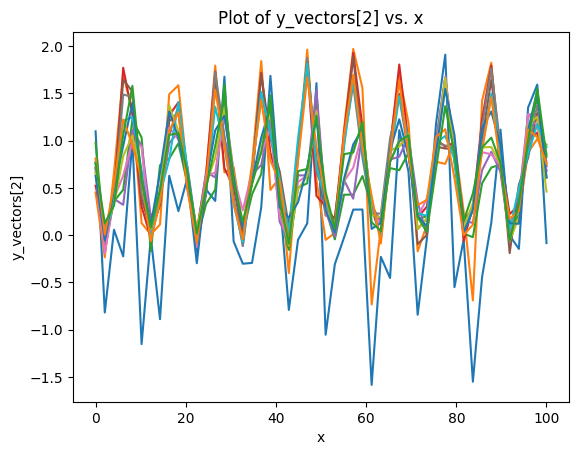

In [ ]:
#plt.plot(x, y_vectors[2])
#plt.plot(x, y_vectors[3])
#plt.plot(x, y_vectors[13])
for i in range(13):
    plt.plot(x, y_vectors[i])
plt.xlabel("x")
plt.ylabel("y_vectors[2]")
plt.title("Plot of y_vectors[2] vs. x")
plt.show()

# Fitting the gaussian process

The full generative model for a GP with a normal outcome, $ y \in \mathbb{R}^N $, with inputs $ x \in \mathbb{R}^N $, for a finite $ N $:

\begin{aligned}
    \rho &\sim \text{InvGamma}(5, 5) \\
    \alpha &\sim \text{normal}(0, 1) \\
    \sigma &\sim \text{normal}(0, 1) \\
    y_0 &\sim \text{multivariate normal}\left(0, K(x \mid \alpha, \rho)\right) \\
    \beta &\sim \text{normal}(0,1)\\
    y_i &\sim \text{normal}((1-β) + \beta y_{i-1}, \sigma) \quad \forall i \in \{1, \ldots, N\}
\end{aligned}



Remember: $$K\left(x \mid \alpha, \rho, \sigma \right)_{i,j} = \alpha^2 \exp \left( -\frac{1}{2\rho^2} \sum_{d=1}^{D} \left(x_{i,d} - x_{j,d}\right)^2 \right) + \delta_{i,j} \sigma^2$$



## Univariate example

In [ ]:
synt_fitGP_LV = """
        data {
          int<lower=1> N;
          array[N] real x;
          vector[N] y;
        }

        transformed data {
          real delta = 1e-9;
        }

        parameters {
          real<lower=0> rho;
          real<lower=0> alpha;
          real<lower=0> sigma;
          real<lower=0> beta;
          vector[N] eta;
        }

        model {
          vector[N] y_0;
          {
            matrix[N, N] L_K;
            matrix[N, N] K = gp_exp_quad_cov(x, alpha, rho);

            // diagonal elements
            for (n in 1:N) {
              K[n, n] = K[n, n] + delta;
            }

            L_K = cholesky_decompose(K);
            y_0 = L_K * eta;
          }

          rho ~ inv_gamma(5, 5);
          alpha ~ std_normal();
          sigma ~ std_normal();
          beta ~ std_normal();
          eta ~ std_normal();

          y[2:N] ~ normal((1-beta) + beta * y[1:(N - 1)] + y_0[2:N], sigma);
        }

"""
# Write model to file
stan_file = "./stan/synt1GP_fitLV.stan"
with open(stan_file, "w") as f:
    print(synt_fitGP_LV, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

09:05:10 - cmdstanpy - INFO - compiling stan file /tmp/tmpk8k1ir9a/tmp7k4lgsb4.stan to exe file /gdrive/MyDrive/Bayesian POLIMI/stan/synt1GP_fitLV
INFO:cmdstanpy:compiling stan file /tmp/tmpk8k1ir9a/tmp7k4lgsb4.stan to exe file /gdrive/MyDrive/Bayesian POLIMI/stan/synt1GP_fitLV
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=synt1GP_fitLV.stan /tmp/tmpk8k1ir9a/tmp7k4lgsb4
cwd: /root/.cmdstan/cmdstan-2.35.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=synt1GP_fitLV.stan --o=/tmp/tmpk8k1ir9a/tmp7k4lgsb4.hpp /tmp/tmpk8k1ir9a/tmp7k4lgsb4.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_

In [ ]:
# Prepare data list for stan
input_data = {
    "N": 50,
    "x": x,
    "y": y_vectors[1],
}
#specify with the same names you put in data!

# Run the sampler
stan_fit = stan_model.sample(data=input_data, chains=4, parallel_chains=4,
                             iter_warmup=1000, iter_sampling=5000)

# Convert chain to arviz format
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /gdrive/MyDrive/Bayesian POLIMI/stan/synt1GP_fitLV info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83nr1v3q/1ejxdf9h.json
09:07:00 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Bayesian POLIMI/stan/synt1GP_fitLV', 'id=1', 'random', 'seed=31090', 'data', 'file=/tmp/tmp83nr1v3q/1ejxdf9h.json', 'output', 'file=/tmp/tmp83nr1v3q/synt1GP_fitLVzvm43o5g/synt1GP_fitLV-20241208090701_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Bayesian POLIMI/stan/synt1GP_fitLV', 'id=3', 'random', 'seed=31090', 'data', 'file=/tmp/tmp83nr1v3q/1ejxdf9h.json', 'output', 'file=/tmp/tmp83nr1v3q/synt1GP_fitLVzvm43o5g/synt1GP_fitLV-20241208090701_3.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Bayesian POLIMI/st

09:10:14 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/gdrive/MyDrive/Bayesian POLIMI/stan/synt1GP_fitLV', 'id=1', 'random', 'seed=31090', 'data', 'file=/tmp/tmp83nr1v3q/1ejxdf9h.json', 'output', 'file=/tmp/tmp83nr1v3q/synt1GP_fitLVzvm43o5g/synt1GP_fitLV-20241208090701_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp83nr1v3q/synt1GP_fitLVzvm43o5g/synt1GP_fitLV-20241208090701_1.csv
 console_msgs (if any):
	/tmp/tmp83nr1v3q/synt1GP_fitLVzvm43o5g/synt1GP_fitLV-20241208090701_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
  

09:10:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 76 divergent transitions (1.5%)
	Chain 2 had 1869 divergent transitions (37.4%)
	Chain 3 had 2839 divergent transitions (56.8%)
	Chain 4 had 564 divergent transitions (11.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
	Chain 1 had 76 divergent transitions (1.5%)
	Chain 2 had 1869 divergent transitions (37.4%)
	Chain 3 had 2839 divergent transitions (56.8%)
	Chain 4 had 564 divergent transitions (11.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (54), generating only 20 plots
  warnings.warn(


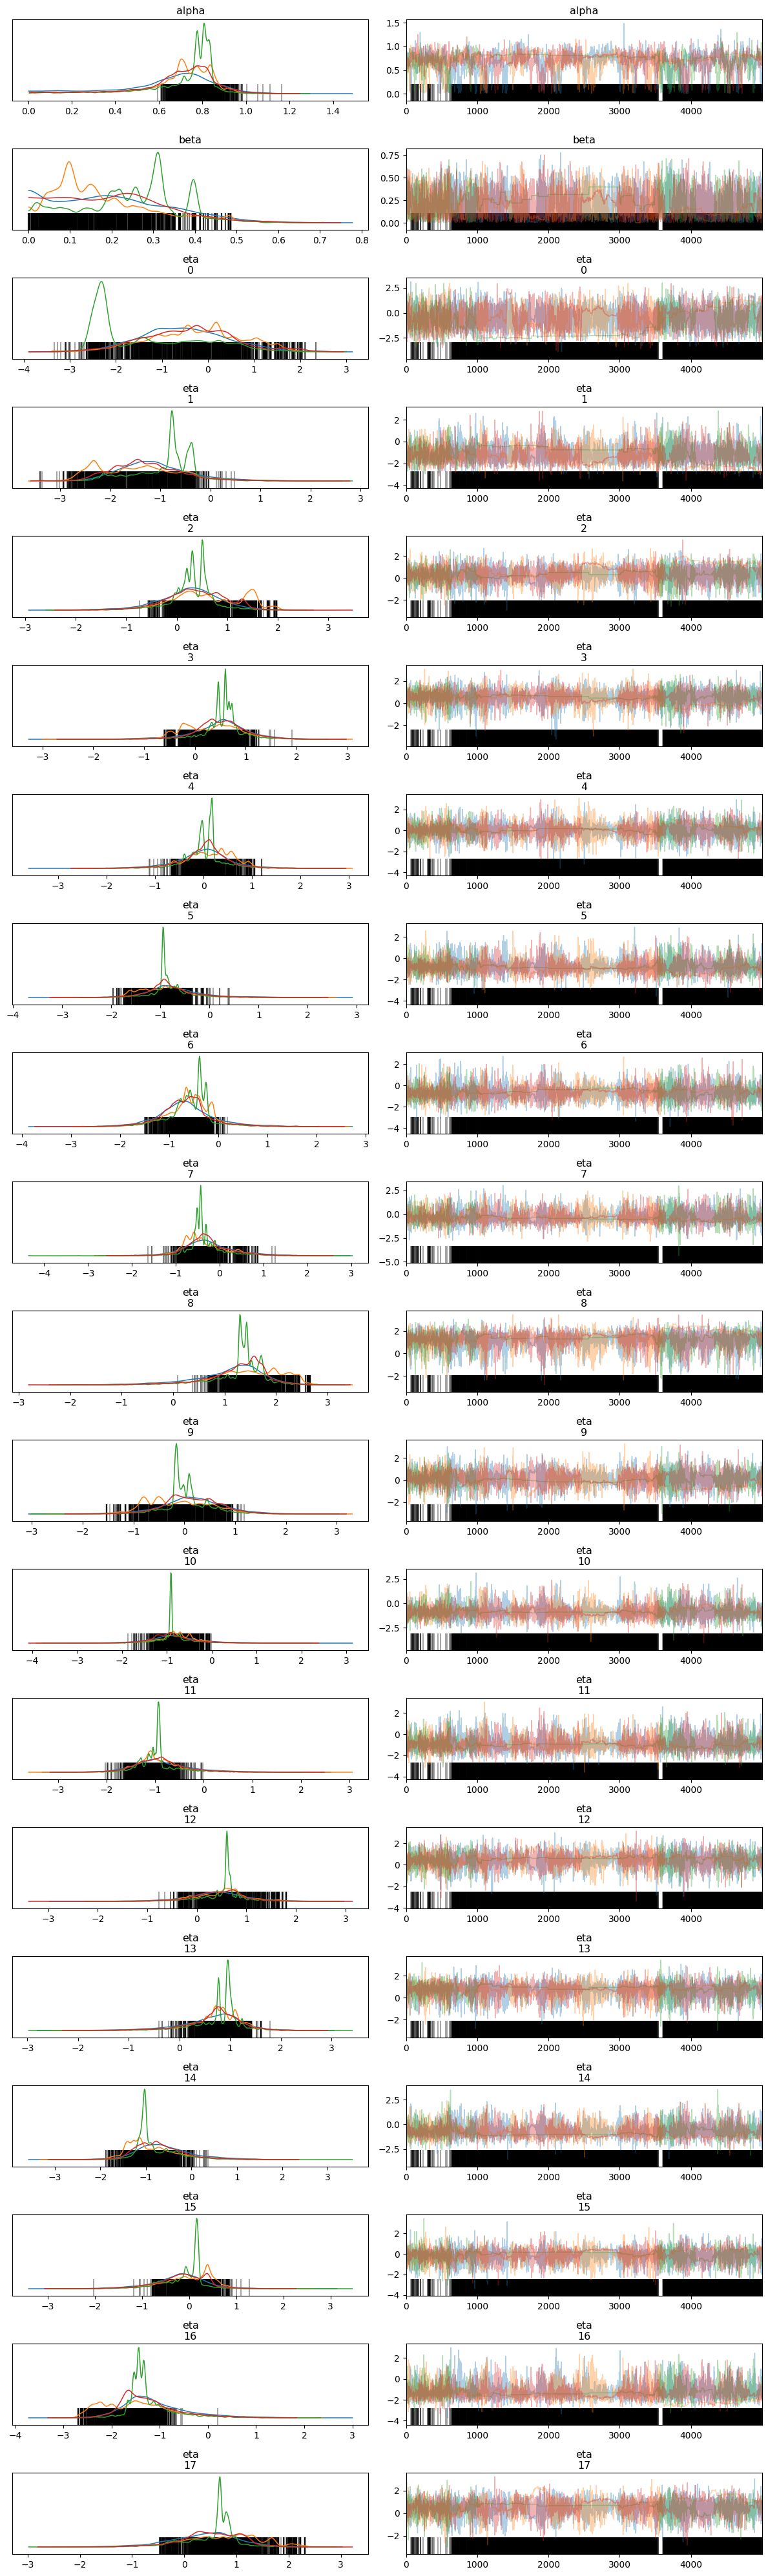

In [ ]:
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()
plt.show()

## Multivariate

In [ ]:
synt_fitGP_ML = """
        data {
          int<lower=1> d;
          int<lower=1> N;
          array[N] real x;
          array[d] vector[N] y;
        }

        parameters {
          real<lower=0> rho;
          real<lower=0> alpha;
          real<lower=0> sigma;
        }

        model {
          matrix[N, N] L_K;
          matrix[N, N] K = gp_exp_quad_cov(x, alpha, rho);
          real sq_sigma = square(sigma);

          // diagonal elements
          for (n in 1:N) {
            K[n, n] = K[n, n] + sq_sigma;
          }

          L_K = cholesky_decompose(K);

          rho ~ inv_gamma(5, 5);
          alpha ~ std_normal();
          sigma ~ std_normal();

          for (n in 2:d) {
            y[n] ~ multi_normal_cholesky(y[n-1], L_K);
          }
        }

"""
# Write model to file
stan_file = "./stan/synt2GP_fitML.stan"
with open(stan_file, "w") as f:
    print(synt_fitGP_ML, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

09:29:34 - cmdstanpy - INFO - compiling stan file /tmp/tmps74q2yrx/tmpjwrs05v3.stan to exe file /gdrive/MyDrive/Bayesian POLIMI/stan/synt2GP_fitML
INFO:cmdstanpy:compiling stan file /tmp/tmps74q2yrx/tmpjwrs05v3.stan to exe file /gdrive/MyDrive/Bayesian POLIMI/stan/synt2GP_fitML
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=synt2GP_fitML.stan /tmp/tmps74q2yrx/tmpjwrs05v3
cwd: /root/.cmdstan/cmdstan-2.35.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=synt2GP_fitML.stan --o=/tmp/tmps74q2yrx/tmpjwrs05v3.hpp /tmp/tmps74q2yrx/tmpjwrs05v3.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_

In [ ]:
# Prepare data list for stan
input_data = {
    "d": 14,
    "N": 50,
    "x": x,
    "y": y_vectors,
}
#specify with the same names you put in data!

# Run the sampler
stan_fit = stan_model.sample(data=input_data, chains=4, parallel_chains=4,
                             iter_warmup=1000, iter_sampling=5000)

# Convert chain to arviz format
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /gdrive/MyDrive/Bayesian POLIMI/stan/synt2GP_fitML info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83nr1v3q/b4bi47xo.json
09:53:20 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Bayesian POLIMI/stan/synt2GP_fitML', 'id=1', 'random', 'seed=76181', 'data', 'file=/tmp/tmp83nr1v3q/b4bi47xo.json', 'output', 'file=/tmp/tmp83nr1v3q/synt2GP_fitMLm7_qaxm1/synt2GP_fitML-20241208095320_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Bayesian POLIMI/stan/synt2GP_fitML', 'id=3', 'random', 'seed=76181', 'data', 'file=/tmp/tmp83nr1v3q/b4bi47xo.json', 'output', 'file=/tmp/tmp83nr1v3q/synt2GP_fitMLm7_qaxm1/synt2GP_fitML-20241208095320_3.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Bayesian POLIMI/stan/synt2GP_fitML', 'id

09:56:28 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/gdrive/MyDrive/Bayesian POLIMI/stan/synt2GP_fitML', 'id=1', 'random', 'seed=76181', 'data', 'file=/tmp/tmp83nr1v3q/b4bi47xo.json', 'output', 'file=/tmp/tmp83nr1v3q/synt2GP_fitMLm7_qaxm1/synt2GP_fitML-20241208095320_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp83nr1v3q/synt2GP_fitMLm7_qaxm1/synt2GP_fitML-20241208095320_1.csv
 console_msgs (if any):
	/tmp/tmp83nr1v3q/synt2GP_fitMLm7_qaxm1/synt2GP_fitML-20241208095320_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
  

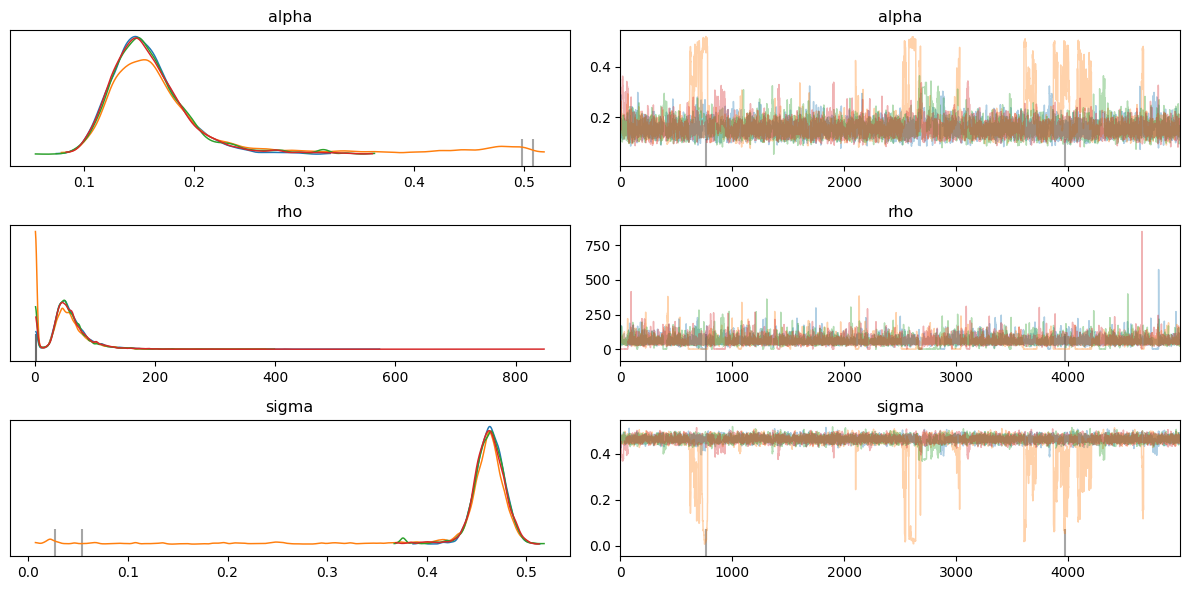

In [ ]:
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()
plt.show()

In [ ]:
synt2_fitGP_ML = """
        data {
          int<lower=1> d;
          int<lower=1> N;
          array[N] real x;
          array[d] vector[N] y;
        }

        parameters {
          real<lower=0> rho;
          real<lower=0> alpha;
          real<lower=0> sigma;
          matrix[N, N] beta;
        }

        model {
          matrix[N, N] L_K;
          matrix[N, N] K = gp_exp_quad_cov(x, alpha, rho);
          real sq_sigma = square(sigma);

          // diagonal elements
          for (n in 1:N) {
            K[n, n] = K[n, n] + sq_sigma;
          }

          L_K = cholesky_decompose(K);

          array[d-1] vector[N] mu;

          for (n in 1:d-1) {
            mu[n] = beta * y[n];

          }

          rho ~ inv_gamma(5, 5);
          alpha ~ std_normal();
          sigma ~ std_normal();
          to_vector(beta) ~ normal(0, 5);

          for (n in 2:d) {
            y[n] ~ multi_normal_cholesky(mu[n-1], L_K);
          }
        }

"""
# Write model to file
stan_file = "./stan/synt3GP_fitML.stan"
with open(stan_file, "w") as f:
    print(synt2_fitGP_ML, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

10:32:52 - cmdstanpy - INFO - compiling stan file /tmp/tmpbbyk2te7/tmptvrpd257.stan to exe file /gdrive/MyDrive/Bayesian POLIMI/stan/synt3GP_fitML
INFO:cmdstanpy:compiling stan file /tmp/tmpbbyk2te7/tmptvrpd257.stan to exe file /gdrive/MyDrive/Bayesian POLIMI/stan/synt3GP_fitML
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=synt3GP_fitML.stan /tmp/tmpbbyk2te7/tmptvrpd257
cwd: /root/.cmdstan/cmdstan-2.35.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=synt3GP_fitML.stan --o=/tmp/tmpbbyk2te7/tmptvrpd257.hpp /tmp/tmpbbyk2te7/tmptvrpd257.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_

In [ ]:
# Prepare data list for stan
input_data = {
    "d": 14,
    "N": 50,
    "x": x,
    "y": y_vectors,
}
#specify with the same names you put in data!

# Run the sampler
stan_fit = stan_model.sample(data=input_data, chains=4, parallel_chains=4,
                             iter_warmup=1000, iter_sampling=5000)

# Convert chain to arviz format
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /gdrive/MyDrive/Bayesian POLIMI/stan/synt3GP_fitML info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp83nr1v3q/3kdd6p47.json
10:34:13 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Bayesian POLIMI/stan/synt3GP_fitML', 'id=1', 'random', 'seed=75804', 'data', 'file=/tmp/tmp83nr1v3q/3kdd6p47.json', 'output', 'file=/tmp/tmp83nr1v3q/synt3GP_fitMLozg08k0v/synt3GP_fitML-20241208103413_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Bayesian POLIMI/stan/synt3GP_fitML', 'id=2', 'random', 'seed=75804', 'data', 'file=/tmp/tmp83nr1v3q/3kdd6p47.json', 'output', 'file=/tmp/tmp83nr1v3q/synt3GP_fitMLozg08k0v/synt3GP_fitML-20241208103413_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:Cm

18:30:41 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/gdrive/MyDrive/Bayesian POLIMI/stan/synt3GP_fitML', 'id=1', 'random', 'seed=75804', 'data', 'file=/tmp/tmp83nr1v3q/3kdd6p47.json', 'output', 'file=/tmp/tmp83nr1v3q/synt3GP_fitMLozg08k0v/synt3GP_fitML-20241208103413_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp83nr1v3q/synt3GP_fitMLozg08k0v/synt3GP_fitML-20241208103413_1.csv
 console_msgs (if any):
	/tmp/tmp83nr1v3q/synt3GP_fitMLozg08k0v/synt3GP_fitML-20241208103413_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
  

18:30:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 23 divergent transitions (0.5%)
	Chain 1 had 4977 iterations at max treedepth (99.5%)
	Chain 2 had 5000 iterations at max treedepth (100.0%)
	Chain 3 had 21 divergent transitions (0.4%)
	Chain 3 had 4979 iterations at max treedepth (99.6%)
	Chain 4 had 13 divergent transitions (0.3%)
	Chain 4 had 4987 iterations at max treedepth (99.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
	Chain 1 had 23 divergent transitions (0.5%)
	Chain 1 had 4977 iterations at max treedepth (99.5%)
	Chain 2 had 5000 iterations at max treedepth (100.0%)
	Chain 3 had 21 divergent transitions (0.4%)
	Chain 3 had 4979 iterations at max treedepth (99.6%)
	Chain 4 had 13 divergent transitions (0.3%)
	Chain 4 had 4987 iterations at max treedepth (99.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


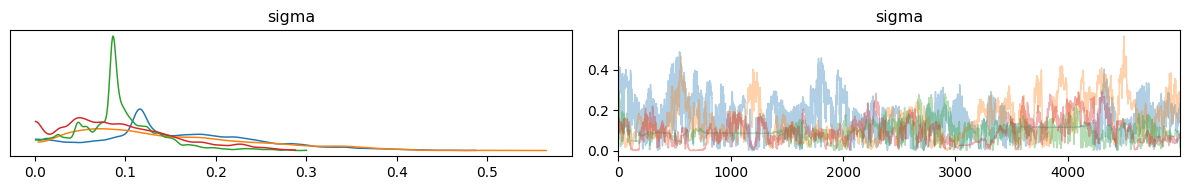

In [ ]:
az.plot_trace(cmdstanpy_data['posterior']['sigma'], compact=False)
plt.tight_layout()
plt.show()

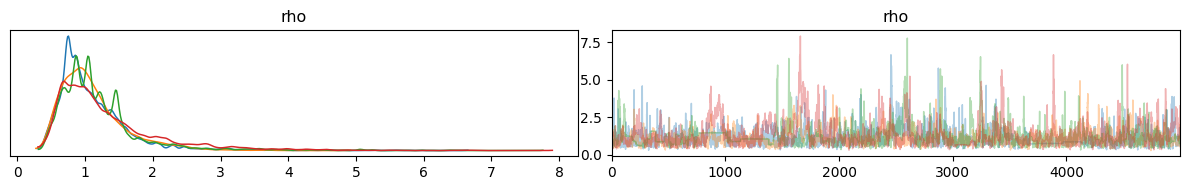

In [ ]:
az.plot_trace(cmdstanpy_data['posterior']['rho'], compact=False)
plt.tight_layout()
plt.show()

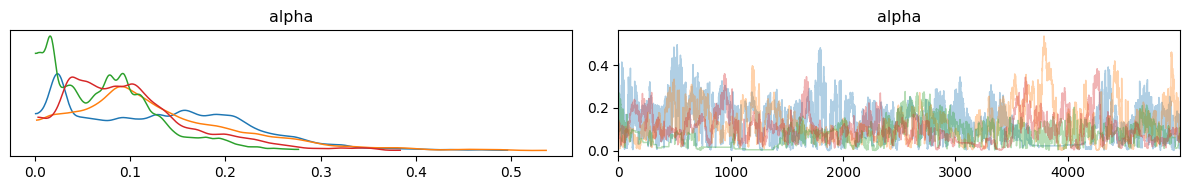

In [ ]:
az.plot_trace(cmdstanpy_data['posterior']['alpha'], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (2500), generating only 20 plots
  warnings.warn(


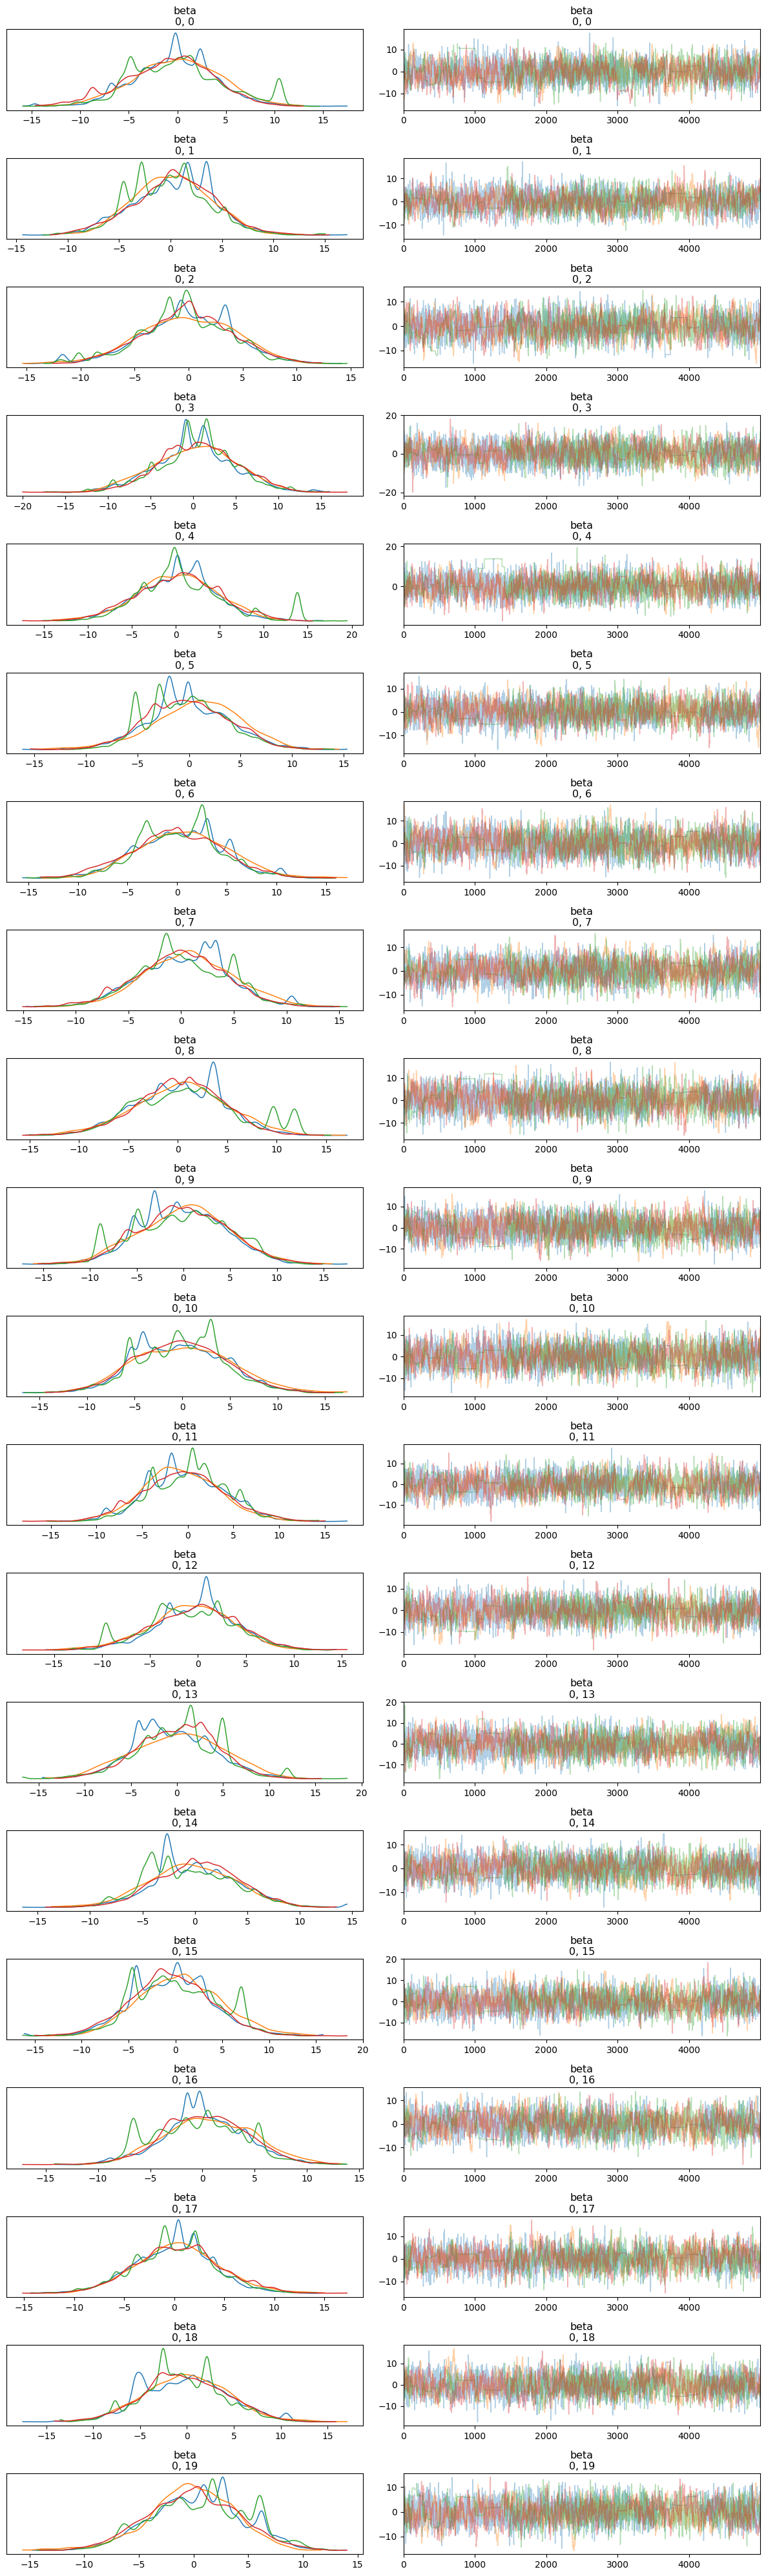

In [ ]:
az.plot_trace(cmdstanpy_data['posterior']['beta'], compact=False)
plt.tight_layout()
plt.show()

# Current Model
This is the model we are going to use for the first phase of the project
$$
  y_t(s) = (1-\beta) \mu(s) + \beta y_{t-1}(s)
$$
The hierarchical bayesian model is as follows:
\begin{aligned}
    y_t &\sim \text{multivariate normal}(\beta y_{t-1}, (1-\beta)^2 K(x \mid \alpha, \rho)) \\
    \rho &\sim \text{InvGamma}(5, 5) \\
    \alpha &\sim \text{normal}(0, 1) \\
    \sigma &\sim \text{normal}(0, 1) \\
    \beta &\sim \text{normal}(0,5)
\end{aligned}

And $$K\left(x \mid \alpha, \rho, \sigma \right)_{i,j} = \alpha^2 \exp \left( -\frac{1}{2\rho^2} \sum_{d=1}^{D} \left(x_{i,d} - x_{j,d}\right)^2 \right) + \delta_{i,j} \sigma^2$$

In [ ]:
synt3_fitGP_ML = """
        data {
          int<lower=1> d;
          int<lower=1> N;
          array[N] real x;
          array[d] vector[N] y;
        }

        transformed data {
          vector[N] m0 = rep_vector(0, N);
        }

        parameters {
          real<lower=0> rho;
          real<lower=0> alpha;
          real<lower=0> sigma;
          real<lower=0> beta;

        }

        model {
          matrix[N, N] L_K;
          matrix[N, N] K = gp_exp_quad_cov(x, alpha, rho);
          real sq_sigma = square(sigma);

          // diagonal elements
          for (n in 1:N) {
            K[n, n] = K[n, n] + sq_sigma;
          }

          L_K = ((1-beta)^2)*cholesky_decompose(K);

          array[d-1] vector[N] mu;

          for (n in 1:d-1) {
            mu[n] = beta * y[n];

          }

          rho ~ inv_gamma(5, 5);
          alpha ~ std_normal();
          sigma ~ std_normal();
          beta ~ normal(0, 5);


          for (n in 2:d) {
            y[n] ~ multi_normal_cholesky(mu[n-1], L_K);
          }
        }

"""
# Write model to file
stan_file = "./stan/synt4GP_fitML.stan"
with open(stan_file, "w") as f:
    print(synt3_fitGP_ML, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

10:53:53 - cmdstanpy - INFO - compiling stan file /tmp/tmp6i7r1d48/tmpxrxkoizd.stan to exe file /gdrive/MyDrive/Bayesian POLIMI/stan/synt4GP_fitML
INFO:cmdstanpy:compiling stan file /tmp/tmp6i7r1d48/tmpxrxkoizd.stan to exe file /gdrive/MyDrive/Bayesian POLIMI/stan/synt4GP_fitML
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=synt4GP_fitML.stan /tmp/tmp6i7r1d48/tmpxrxkoizd
cwd: /root/.cmdstan/cmdstan-2.35.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=synt4GP_fitML.stan --o=/tmp/tmp6i7r1d48/tmpxrxkoizd.hpp /tmp/tmp6i7r1d48/tmpxrxkoizd.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_

In [ ]:
# Prepare data list for stan
input_data = {
    "d": 14,
    "N": 50,
    "x": x,
    "y": y_vectors,
}
#specify with the same names you put in data!

# Run the sampler
stan_fit = stan_model.sample(data=input_data, chains=4, parallel_chains=4,
                             iter_warmup=1000, iter_sampling=5000)

# Convert chain to arviz format
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /gdrive/MyDrive/Bayesian POLIMI/stan/synt4GP_fitML info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvv2711v5/bh45c2tv.json
10:54:42 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Bayesian POLIMI/stan/synt4GP_fitML', 'id=2', 'random', 'seed=32445', 'data', 'file=/tmp/tmpvv2711v5/bh45c2tv.json', 'output', 'file=/tmp/tmpvv2711v5/synt4GP_fitML8g9_3clt/synt4GP_fitML-20241209105442_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Bayesian POLIMI/stan/synt4GP_fitML', 'id=1', 'random', 'seed=32445', 'data', 'file=/tmp/tmpvv2711v5/bh45c2tv.json', 'output', 'file=/tmp/tmpvv2711v5/synt4GP_fitML8g9_3clt/synt4GP_fitML-20241209105442_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:Cm

11:02:58 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/gdrive/MyDrive/Bayesian POLIMI/stan/synt4GP_fitML', 'id=1', 'random', 'seed=32445', 'data', 'file=/tmp/tmpvv2711v5/bh45c2tv.json', 'output', 'file=/tmp/tmpvv2711v5/synt4GP_fitML8g9_3clt/synt4GP_fitML-20241209105442_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvv2711v5/synt4GP_fitML8g9_3clt/synt4GP_fitML-20241209105442_1.csv
 console_msgs (if any):
	/tmp/tmpvv2711v5/synt4GP_fitML8g9_3clt/synt4GP_fitML-20241209105442_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
  

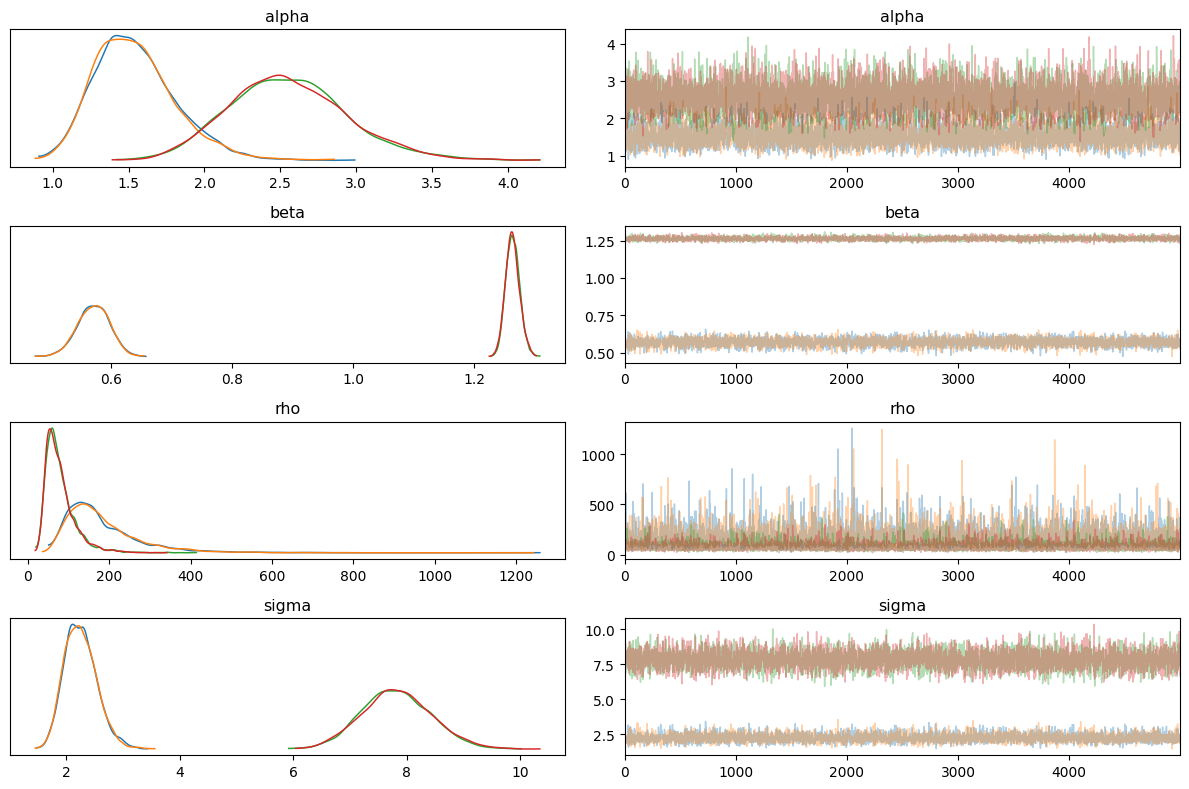

In [ ]:
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()
plt.show()

In [ ]:
betas = cmdstanpy_data['posterior']['beta'][3]
rhos = cmdstanpy_data['posterior']['rho'][3]
alphas = cmdstanpy_data['posterior']['alpha'][3]
sigmas = cmdstanpy_data['posterior']['sigma'][3]
beta = betas.mean().item() # convert to float
rho = rhos.mean().item() # convert to float
alpha = alphas.mean().item() # convert to float
sigma = sigmas.mean().item() # convert to float

In [ ]:
K = np.zeros((N, N))
for i in range((N )):
    K[i, i] = 1 + sigma
    for j in range((i + 1), N):
        # Use ** for exponentiation instead of ^
        K[i, j] = alpha**2 * np.exp(-(1/(2*rho**2)) * np.square(x[i] - x[j]))
        K[j, i] = K[i, j]

In [ ]:
import numpy as np
mean = np.zeros(N)
mu = np.random.multivariate_normal(mean, K, 1)
mu = mu.flatten() # flatten to 1D numpy array

In [ ]:
len(y_vectors[12])

50

In [ ]:
len(mu)

50

In [ ]:
y_sim = beta*y_vectors[12] + (1-beta)*mu

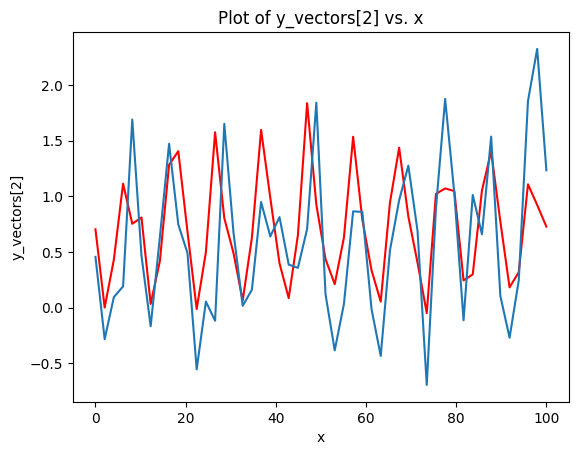

In [ ]:
plt.plot(x, y_vectors[13], color="red")
plt.plot(x, y_sim)
plt.xlabel("x")
plt.ylabel("y_vectors[2]")
plt.title("Plot of y_vectors[2] vs. x")
plt.show()

Note: [extension to glm gaussian process](https://mc-stan.org/docs/stan-users-guide/gaussian-processes.html#discrete-outcomes-with-gaussian-processes) (not used in the project but interesting comunque)

Note for the future: [here to make predictions](https://mc-stan.org/docs/stan-users-guide/gaussian-processes.html#discrete-outcomes-with-gaussian-processes)